In [1]:
import os, sys
import glob
import json
import pandas as pd
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import face_recognition
import numpy as np

from tqdm import tqdm_notebook
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
import numpy as np
import keras
import sklearn.metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers, initializers
import random

# Predicting the similar actor

### The neural network that identifies the gender of the person from the picture

we have already downloaded 500 pics for each gender (the code in the file download.ipynb)

In [2]:
"""
I wrote "man" and "woman" in the dict in russian because the request 
with "man" gave a lot of not male persons on pics or no persons at all 
and were FOR men bit not WITH men
"""
gender_dict={'мужчина':0, 'женщина':1} 

make the embeding for each pic, except ones that have more than 1 or no faces

In [3]:
embedings = np.empty(128)
target = [] #the y column

for gender in list(gender_dict.keys()):
    # the list of the pics in the folder
    images = os.listdir(f"gender/{gender}")

    for img in images:
        # load the img
        face = face_recognition.load_image_file(f"gender/{gender}/{img}")
        # have the coordinates of the face
        face_bounding_boxes = face_recognition.face_locations(face)

        # if there're more than 1 face or noone skip the pic
        if len(face_bounding_boxes) == 1:
            try:
                # getting the embeding
                face_enc = face_recognition.face_encodings(face)[0]
                # add to the matrix
                embedings = np.vstack((embedings, face_enc))
                # add the gender to the y 
                target.append(gender_dict[gender])
            except Exception as ex:
                print(f'Error message {ex}')

# drop the 1 empty element
embedings = embedings[1:].astype(np.float)
target= np.array(target)
target=tf.keras.utils.to_categorical(target, num_classes=2, dtype='int8')

divide into train and test samples and teach the neural network

In [4]:
X_train, X_test, y_train, y_test = train_test_split(embedings, target, test_size=0.3, 
                                                    stratify=target,  random_state=5)

In [5]:
tf.random.set_seed(930)
init=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=560)
init1=initializers.Constant(value=1e-3)

model = Sequential() 
model.add(Dense(70, input_dim=embedings.shape[1], activation='relu', 
                kernel_initializer=init, bias_initializer=init1)) 
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=6, batch_size=100, verbose=1)
print('\n')
scores=model.evaluate(tf.expand_dims(X_test, axis=-1), y_test) 

Epoch 1/6
5/5 [==============================] - 1s 6ms/step - loss: 0.6854 - accuracy: 0.6580
Epoch 2/6
5/5 [==============================] - 0s 7ms/step - loss: 0.6705 - accuracy: 0.7480
Epoch 3/6
5/5 [==============================] - 0s 5ms/step - loss: 0.6543 - accuracy: 0.7340
Epoch 4/6
5/5 [==============================] - 0s 7ms/step - loss: 0.6351 - accuracy: 0.8220
Epoch 5/6
5/5 [==============================] - 0s 5ms/step - loss: 0.6165 - accuracy: 0.9060
Epoch 6/6
5/5 [==============================] - 0s 7ms/step - loss: 0.5932 - accuracy: 0.9640


7/7 [==============================] - 0s 3ms/step - loss: 0.5825 - accuracy: 0.9860


predicting the gender from the pic

### The model that predicts the actor

we have already downloaded 10 pics for each actor (the code in the file download.ipynb)

check that face_recognition identifies faces correctly

In [6]:
# load the pic
image = face_recognition.load_image_file(".\dataset\Emma_Watson\Emma Watson_7.jpeg")

# get the coordinates of the face
face_locations = face_recognition.face_locations(image)

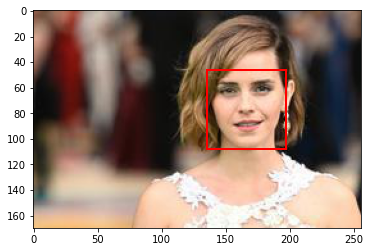

In [7]:
xy = (face_locations[0][3], face_locations[0][0])

width = face_locations[0][1] - face_locations[0][3]
height = face_locations[0][2] - face_locations[0][0]

plt.imshow(image)

# Get the current axes
ax = plt.gca()

# rectangle on the face
rect = patches.Rectangle(xy, width, height, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect);

In [8]:
with open('actors.txt') as json_file:
    actors = json.load(json_file)

In [9]:
#give the id to each actor
dict_man = dict()
for i, key in enumerate(actors['man']):
    dict_man[key] = i
    

dict_woman = dict()
for i, key in enumerate(actors['woman']):
    dict_woman[key] = i

dict_woman

{'Alicia_Vikander': 0,
 'Amy_Adams': 1,
 'Andie_MacDowell': 2,
 'Angelina_Jolie': 3,
 'Anne_Hathaway': 4,
 'Cameron_Diaz': 5,
 'Carey_Mulligan': 6,
 'Cate_Blanchett': 7,
 'Catherine_Zeta-Jones': 8,
 'Charlize_Theron': 9,
 'Claire_Forlani': 10,
 'Demi_Moore': 11,
 'Drew_Barrymore': 12,
 'Elizabeth_Taylor': 13,
 'Emma_Stone': 14,
 'Emma_Watson': 15,
 'Eva_Mendes': 16,
 'Frances_McDormand': 17,
 'Gwyneth_Paltrow': 18,
 'Halle_Berry': 19,
 'Hilary_Swank': 20,
 'Jennifer_Aniston': 21,
 'Jessica_Biel': 22,
 'Jessica_Chastain': 23,
 'Jodie_Foster': 24,
 'Julia_Roberts': 25,
 'Julianne_Moore': 26,
 'Juliette_Binoche': 27,
 'Kate_Winslet': 28,
 'Keira_Knightley': 29,
 'Kim_Basinger': 30,
 'Kirsten_Dunst': 31,
 'Kristin_Scott_Thomas': 32,
 'Lady_Gaga': 33,
 'Maggie_Gyllenhaal': 34,
 'Marion_Cotillard': 35,
 'Meg_Ryan': 36,
 'Megan_Fox': 37,
 'Melanie_Laurent': 38,
 'Meryl_Streep': 39,
 'Michelle_Pfeiffer': 40,
 'Milla_Jovovich': 41,
 'Naomi_Watts': 42,
 'Natalie_Portman': 43,
 'Natasha_Henstridg

In [10]:
# embedings for actors
embedings_man=np.empty(128)
target_man=[]

for person in tqdm_notebook(list(dict_man.keys())):
    files = len(glob.glob(f'dataset/{person}/*'))   
    if files < 2:  #because too few for train and test at the same time
        print(f'Delete from dataset: {person}')
    else:
        # get the list of pics from the folder
        images = os.listdir(f"./dataset/{person}")
        len_images = len(images)

        for num, person_img in enumerate(images):
            try:
                if person_img != '.DS_Store':
                    # loading the image
                    face = face_recognition.load_image_file(
                        f"dataset/{person}/{person_img}")
                    # get the coordinates of the face
                    face_bounding_boxes = face_recognition.face_locations(face)

                    # miss the pic if there are more than 1 face or noone
                    if len(face_bounding_boxes) == 1:
                        try:
                            # make embeding
                            face_enc = face_recognition.face_encodings(face)[0]
                            embedings_man = np.vstack((embedings_man, face_enc))
                            # add the name of the actor to y column
                            target_man.append(dict_man[person])

                        except Exception as ex:
                            print(f'Error message {ex}')
            except Exception as ex:
                print(f'Error message {ex}')
                
embedings_man = embedings_man[1:] #delete the 1 empty element

  0%|          | 0/74 [00:00<?, ?it/s]

In [11]:
# embedings for actresses
embedings_woman=np.empty(128)
target_woman=[]

for person in tqdm_notebook(list(dict_woman.keys())):
    files = len(glob.glob(f'dataset/{person}/*'))   
    if files < 2: 
        print(f'Delete from dataset: {person}')
    else:
        # get the list of pics from the folder
        images = os.listdir(f"./dataset/{person}")
        len_images = len(images)

        for num, person_img in enumerate(images):
            try:
                if person_img != '.DS_Store':
                    # loading the image
                    face = face_recognition.load_image_file(
                        f"dataset/{person}/{person_img}")
                    # get the coordinates of the face
                    face_bounding_boxes = face_recognition.face_locations(face)

                    # miss the pic if there are more than 1 face or noone
                    if len(face_bounding_boxes) == 1:
                        try:
                            # make embeding
                            face_enc = face_recognition.face_encodings(face)[0]
                            embedings_woman = np.vstack((embedings_woman, face_enc))
                            # add the name of the actor to y column
                            target_woman.append(dict_woman[person])

                        except Exception as ex:
                            print(f'Error message {ex}')
            except Exception as ex:
                print(f'Error message {ex}')
                
embedings_woman = embedings_woman[1:] #delete the 1 empty element

  0%|          | 0/62 [00:00<?, ?it/s]

Training the model

In [171]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    embedings_woman, target_woman, test_size=0.3, stratify=target_woman, random_state=42)

mod_woman = LogisticRegression(solver='liblinear', fit_intercept=False, class_weight='balanced')
#balanced class_weight because women like to change their hair color

mod_woman.fit(X_train_w, y_train_w)

acc=accuracy_score(y_test_w, mod_woman.predict(X_test_w))
print(f'accuracy score = {acc}')

accuracy score = 0.9736842105263158


In [108]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    embedings_man, target_man, test_size=0.3, stratify=target_man, random_state=42)

mod_man = LogisticRegression(solver='liblinear', fit_intercept=False, class_weight='balanced')
mod_man.fit(X_train_m, y_train_m)

acc=accuracy_score(y_test_m, mod_man.predict(X_test_m))
print(f'accuracy score = {acc}')

accuracy score = 0.96045197740113


### Predicting

**here write the addres of the pic you want to predict the actor for**

In [172]:
PATH='test_pic.jpg' 
SIZE=256     #the size for resizing the pic

the function that make the pic smaller for quicker work

In [173]:
def resize_image(SIZE, image):
    # get the size
    size = image.size

    # get the coeff to reshape one of the pict to needed size
    coef = SIZE / size[0]
    # changing the size
    resized_image = image.resize(
        (int(size[0] * coef), int(size[1] * coef)))
    res_image = resized_image.convert('RGB')
    return res_image

In [174]:
image = Image.open(PATH)
res_image = resize_image(SIZE, image)
res_image.save(PATH)

predicting the gender

woman


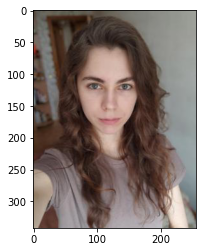

In [175]:
emb=np.empty(128)
face = face_recognition.load_image_file(PATH)
face_bounding_boxes = face_recognition.face_locations(face)

if len(face_bounding_boxes) != 1:
    print('Problem with find face')
else:
    # embeding making
    face_enc = face_recognition.face_encodings(face)[0]
    emb = np.vstack((emb, face_enc))
    emb=emb[1:].astype(np.float)

    predict = model.predict([emb])
    predict=np.argmax(predict)
if predict==0:
    
    #the  variable that gets the predicted gender
    identified_g='man'
    print(identified_g)
else:
    identified_g='woman'
    print(identified_g)
plt.imshow(Image.open(PATH));

if the person on the pic is a man predict only between actors, for women - only actresses

In [176]:
if identified_g=='man':
    actor_model=mod_man
    dict_labels=dict_man
elif identified_g=='woman':
    actor_model=mod_woman
    dict_labels=dict_woman

In [177]:
def predict_actor(path, model, dict_labels):
    face = face_recognition.load_image_file(path)
    face_bounding_boxes = face_recognition.face_locations(face)
    
    if len(face_bounding_boxes) != 1:
        print('Problem with find face')
    else:
        # make embeding 
        face_enc = face_recognition.face_encodings(face)[0]
        
        # predict actress/actor
        predict = model.predict([face_enc])
        predict_labels = list(dict_labels.keys())[list(dict_labels.values()).index(predict)]
        
        predict_proba = model.predict_proba([face_enc])
        
        return predict_labels, predict_proba

In [178]:
predict_name, predict_proba = predict_actor(PATH, actor_model, dict_labels)
predict_name

'Emma_Stone'

In [179]:
# таблица со скорами
df = pd.DataFrame()

df['act'] = list(dict_labels.keys())
df['score'] = predict_proba[0]

df.sort_values(by='score')[::-1]

,act,score
14,Emma_Stone,0.024704
15,Emma_Watson,0.024147
46,Nina_Dobrev,0.023605
1,Amy_Adams,0.020861
35,Marion_Cotillard,0.019284
...,...,...
11,Demi_Moore,0.012664
30,Kim_Basinger,0.012108
39,Meryl_Streep,0.011854
7,Cate_Blanchett,0.011686


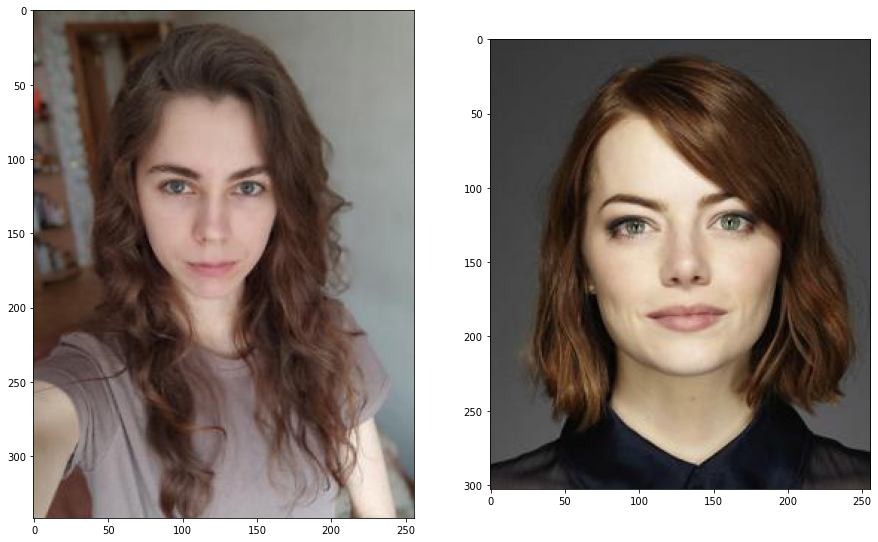

In [183]:
num_image = 9
name=predict_name.replace('_', ' ')

image1 = face_recognition.load_image_file(PATH)
image2 = face_recognition.load_image_file(f"dataset/{predict_name}/{name}_{num_image}.jpeg")

fig, ax = plt.subplots(1, 2, figsize=(15,15))

ax[0].imshow(image1)
ax[1].imshow(image2);

### Getting the mean cosine

In [181]:
def comparison(path_test, name_act, num_image):
    # the test face
    face_1 = face_recognition.load_image_file(path_test)
    face_enc_1 = face_recognition.face_encodings(face_1)[0]
    
    # the actor
    path_act = f"dataset/{predict_name}/{name}_{num_image}.jpeg"
    
    face_2 = face_recognition.load_image_file(path_act)
    face_enc_2 = face_recognition.face_encodings(face_2)[0]
    
    return cosine_similarity(face_enc_1.reshape(1, -1), face_enc_2.reshape(1, -1))[0]

In [182]:
len_files = len(glob.glob(f'dataset/{predict_name}/*'))
cos = []

for i in tqdm_notebook(range(1, len_files+1, 1)):
    try:
        cos_ = comparison(PATH, predict_name, i)
        cos.append(cos_)
        print(i, cos_)
    except Exception as ex:
        print(f'message: {ex}')
        
print(f'Mean score = {np.mean(cos)}')

  0%|          | 0/10 [00:00<?, ?it/s]

1 [0.88711788]
2 [0.8743924]
3 [0.90064996]
4 [0.85646715]
5 [0.88846191]
6 [0.88941113]
7 [0.88096701]
8 [0.90992267]
9 [0.89054328]
10 [0.88352012]
Mean score = 0.8861453523276623
